In [127]:
import os
import numpy as np
import pandas as pd
from scipy import fft, signal
from matplotlib import pyplot as plt
from tqdm import tqdm

from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.model_selection import train_test_split, KFold
from sklearn.preprocessing import StandardScaler, OneHotEncoder

from tensorflow import keras
from tensorflow.keras.optimizers import Adam

from mne.io import read_raw_brainvision

# Useful vars

In [128]:
UNICORN_CH_NAMES = ['Fz', 'C3', 'C4', 'Pz', 'PO7', 'Oz', 'PO8']

# Custom functions

In [137]:
def load_brain_data(subjects, ch_names, object_names, data_dir,
                    make_plots=True, load_verbose=False,
                    notch_filt_hz=(50, 150), hz_range=(0.5, 125), segment_len=50,
                    file_format=None, info_format=None):
    if not file_format:
        file_format = 'sub-{s}_task-rsvp_eeg.vhdr'
    if not info_format:
        info_format = 'sub-{s}_task-rsvp_events.tsv'
        
    X, Y, subject_n = [], [], []
    
    for subject in subjects:
        raw = read_raw_brainvision(os.path.join(data_dir, file_format.format(s=subject)),
                                   verbose=load_verbose)
        raw.pick_channels(ch_names)
        raw.load_data()
        raw.notch_filter(freqs=notch_filt_hz, verbose=load_verbose)
        raw.filter(l_freq=hz_range[0], h_freq=hz_range[1], verbose=load_verbose)
        
        if make_plots:
            raw.plot_sensors(show_names=True);
            raw.plot_psd(average=True);
    
        data = raw.get_data()
        info = pd.read_csv(os.path.join(data_dir, info_format.format(s=subject)), delimiter='\t')

        Xsub, Ysub = prepare_dataset(data, info, object_names, segment_len=segment_len)
        X.extend(Xsub)
        Y.extend(Ysub)
        subject_n.extend([subject] * len(Ysub))
    return np.array(X), np.array(Y), subject_n


def scale_3d_train_and_test(X_train, X_test):
    X_train_c, X_test_c = X_train.copy(), X_test.copy()
    for i in range(X_train_c.shape[1]):
        scaler = StandardScaler()
        scaler.fit(X_train_c[:, i, :])
        X_train_c[:, i, :] = scaler.transform(X_train_c[:, i, :])
        X_test_c[:, i, :] = scaler.transform(X_test_c[:, i, :])
    return X_train_c, X_test_c


def prepare_dataset(data, info, object_names, segment_len=50):
    X, Y = [], []
    for obj_name in object_names:
        if obj_name not in pd.unique(info['object']):
            raise KeyError(f'Class "{obj_name}" not found in info file! Check your spelling <3')
        for i in info[info['object'] == obj_name]['onset']:
            X.append(data[:, i: i + segment_len])
            Y.append(obj_name)
    Y = OneHotEncoder(sparse=False).fit_transform(np.array(Y).reshape(-1, 1))
    return X, Y

# Models

In [135]:
def get_model(n_classes, n_channels, lr, metrics, segment_len=50):
    model = keras.models.Sequential()
    
    model.add(keras.layers.Dense(128, 
                                 input_shape=(n_channels, segment_len), 
                                 activation='relu'))
    model.add(keras.layers.Dropout(0.2))
    model.add(keras.layers.Dense(128, activation='relu'))
    model.add(keras.layers.Dropout(0.2))
    
    # take care of channels
    model.add(keras.layers.Permute((2, 1)))
    model.add(keras.layers.Dense(1, activation='relu'))
    model.add(keras.layers.Flatten())
    
    model.add(keras.layers.Dense(n_classes, activation='softmax'))
    model.compile(optimizer=Adam(learning_rate=lr), 
                  loss='categorical_crossentropy',
                  metrics=metrics)
    return model


def train_with_kfold(X, Y, n_splits, lr, epochs, metrics,
                     to_scale=True, random_seed=42):
    kfold = KFold(n_splits=n_splits, shuffle=True, random_state=random_seed)
    train_progress = []
    
    print(f'X shape: {X.shape}; Y shape: {Y.shape}')

    for i, (train, test) in enumerate(kfold.split(X, Y)):
        model = get_model(n_classes=len(Y[0]), n_channels=X.shape[1], 
                          lr=lr, metrics=metrics)
        
        X_train, Y_train = X[train], Y[train]
        X_test, Y_test = X[test], Y[test]
        if to_scale:
            X_train, X_test = scale_3d_train_and_test(X_train, X_test)
        
        history = model.fit(X_train, Y_train, epochs=epochs, 
                            validation_data=(X_test, Y_test),
                            verbose=0)
        scores = {}
        metric_names = list(history.history.keys())
        
        for metric in metric_names:
            scores[metric] = history.history[metric]
        train_progress.append(scores)
    
    for metric in metric_names[:len(metric_names)//2]:
        plt.figure(figsize=(10, 4))
        for n, fold in enumerate(train_progress):
            plt.plot(range(epochs), fold[metric], c='#00CC00')
            plt.plot(range(epochs), fold[f'val_{metric}'], c='#CC0000')
        plt.title(f'{metric} (green=train, red=val)')
        plt.xlabel('Epochs')
        plt.show()

# How to use this code

Copy-paste this code:

```python
X, Y, _ = load_brain_data(subjects=['01'], 
                          ch_names=['Pz'], 
                          object_names=['piano', 'lettuce'],
                          data_dir='data/eeg64')

train_with_kfold(X, Y, n_splits=6, lr=0.01, 
                 epochs=50, metrics=['accuracy'])
```

Change parameters accordingly:
* `load_brain_data`:
    * `subjects` : subject codes (can be several);
    * `ch_names` : which channels to use (can be several). **Incorrect channel names won't throw an error, so check data shapes!**
    * `object_names` : which objects (classes) to use; will throw a KeyError if name is not found in the info file;
    * `data_dir` : where to search for files;
    * (optional) `make_plots` : True (default) or False, turn plots on/off;
    * (optional) `load_verbose`: True or False (default), print loading and filtering info;
    * **!!!** (optional) `file_format` : common name of data files. Should contain an `{s}` placeholder for subject's code
        * e.g.: `file_format='sub-{s}_task-rsvp_eeg.vhdr'` with `subjects=['01', '02']` will search for 'sub-01_task-rsvp_eeg.vhdr' and 'sub-02_task-rsvp_eeg.vhdr';
    * **!!!** (optional) `info_format` : same for the table with info;
    
    
* `train_with_kfold`:
    * `n_splits` : number of KFold splits;
    * `lr`: learning rate (for Adam optimizer);
    * `epochs`: N of training epochs;
    * `metrics`: Keras metrics to calculate together with loss;
    * (optional) `to_scale` : True (default) or False, whether to scale the data (using only train data as fit);

## 1 subject, 2 classes, 1 channel

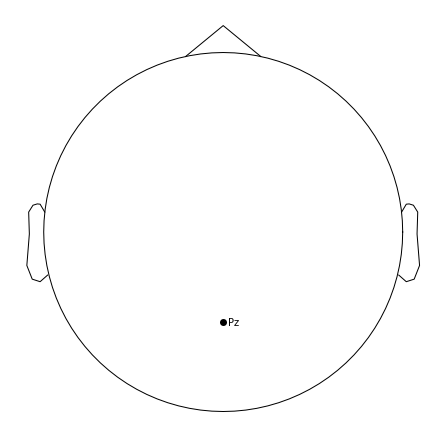

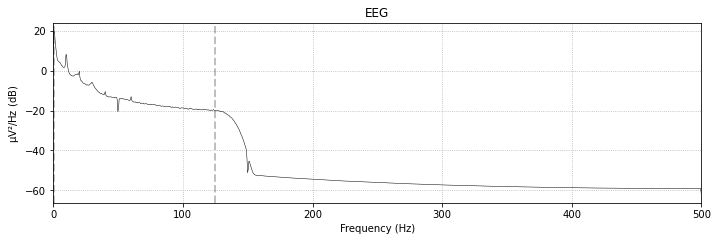

X shape: (24, 1, 50); Y shape: (24, 2)


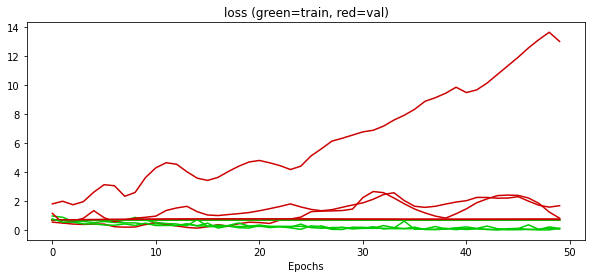

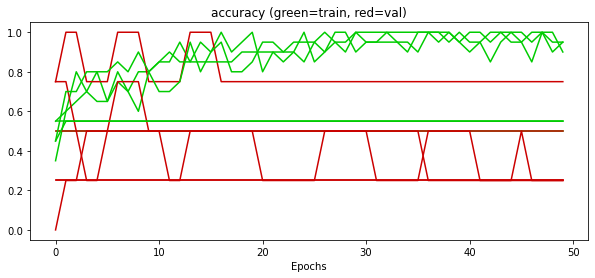

In [139]:
X, Y, _ = load_brain_data(subjects=['01'], 
                          ch_names=['Pz'], 
                          object_names=['piano', 'lettuce'],
                          data_dir='data/eeg64')

train_with_kfold(X, Y, n_splits=6, lr=0.01, 
                 epochs=50, metrics=['accuracy'])

# 1 subject, 4 classes, 1 channel

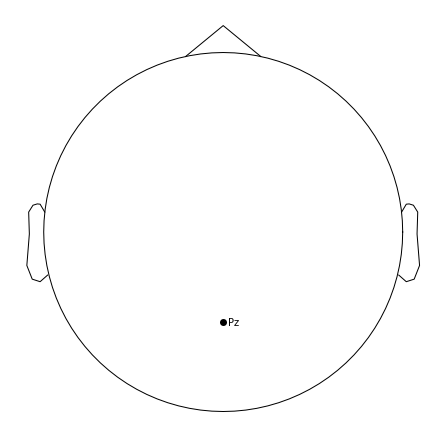

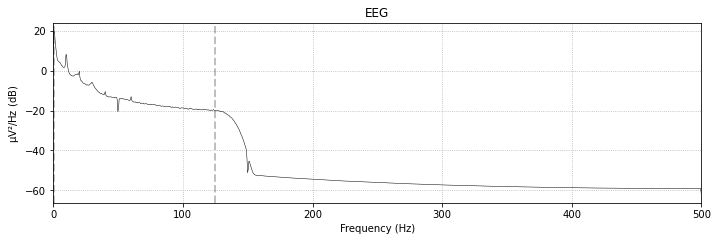

X shape: (48, 1, 50); Y shape: (48, 4)


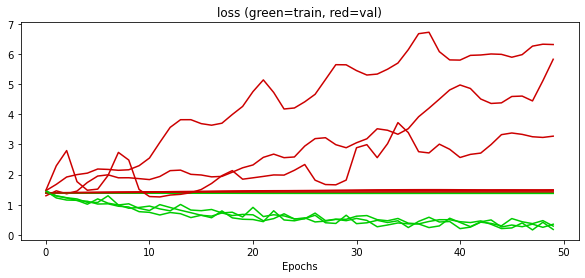

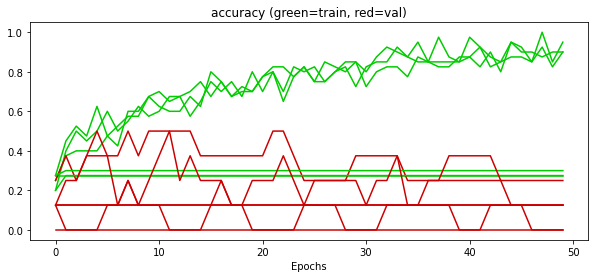

In [141]:
X, Y, _ = load_brain_data(subjects=['01'], 
                          ch_names=['Pz'], 
                          object_names=['piano', 'lettuce', 'amplifier', 'alligator'],
                          data_dir='data/eeg64')

train_with_kfold(X, Y, n_splits=6, lr=0.01, 
                 epochs=50, metrics=['accuracy'])

# 2 subjects, 2 classes, 1 channel

X shape: (48, 1, 50); Y shape: (48, 2)


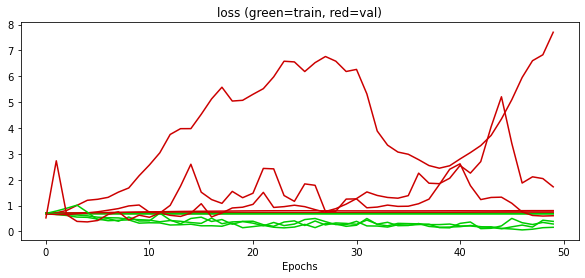

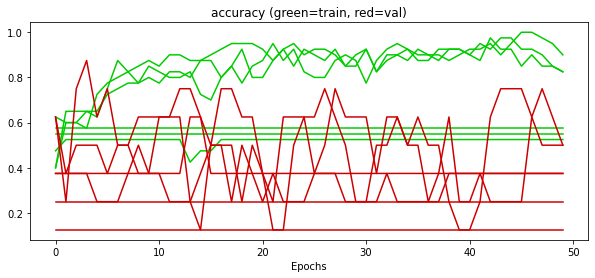

In [143]:
X, Y, subject_n = load_brain_data(subjects=['01', '02'], 
                                  ch_names=['Pz'], 
                                  object_names=['piano', 'lettuce'],
                                  data_dir='data/eeg64',
                                  make_plots=False)

train_with_kfold(X, Y, n_splits=6, lr=0.01, 
                 epochs=50, metrics=['accuracy'])

# 2 subjects, 2 classes, 7 channels

X shape: (48, 7, 50); Y shape: (48, 2)


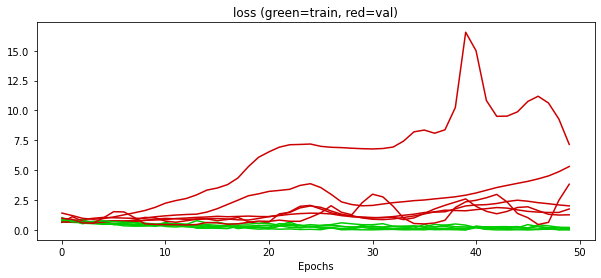

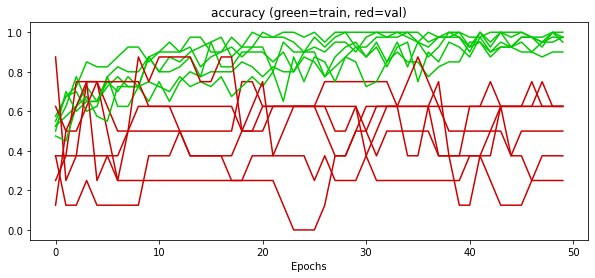

In [144]:
X, Y, subject_n = load_brain_data(subjects=['01', '02'], 
                                  ch_names=UNICORN_CH_NAMES, 
                                  object_names=['piano', 'lettuce'],
                                  data_dir='data/eeg64',
                                  make_plots=False)

train_with_kfold(X, Y, n_splits=6, lr=0.01, 
                 epochs=50, metrics=['accuracy'])